In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import hog

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics, decomposition
from sklearn.metrics import confusion_matrix


- Modular class to handle:

  - showing images,

  - reading from disk,

  - converting to grayscale,

  - resizing to a fixed size.

In [15]:
class ImagePreprocessing:
    def show_image(self, image, title='Image', cmap_type='gray'):
        plt.imshow(image, cmap=cmap_type)
        plt.title(title)
        plt.axis('off')
        plt.show()
    def read_images(self, filenames, path):
        return [imread(os.path.join(path, fname)) for fname in filenames]

    def to_grayscale(self, images):
        return [rgb2gray(img) for img in images]

    def resize_images(self, images, size=(512, 512)):
        return [resize(img, size, anti_aliasing=True) for img in images]


- Check and show one sample image from the folder to confirm data exists and can be loaded properly.



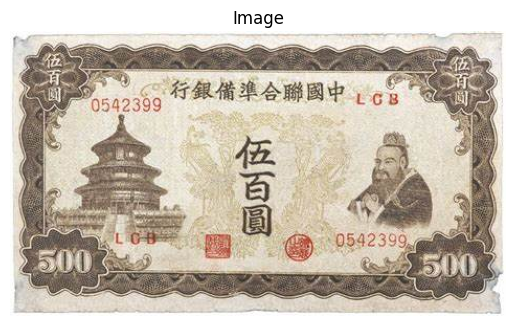

In [19]:
china_path = '/content/china'
china_files = os.listdir(china_path)

if china_files:
    first_china_image_path = os.path.join(china_path, china_files[10])
    try:
        img = imread(first_china_image_path)
        ImagePreprocessing().show_image(img)
    except FileNotFoundError:
        print(f"Error: File not found at {first_china_image_path}")
else:
    print(f"Error: No files found in {china_path}")

- Read all image files from the China folder using the earlier defined function.



In [14]:
ImagePreprocessing.read_images(ImagePreprocessing(), os.listdir('/content/china'), '/content/china')

[array([[[1, 1, 1],
         [1, 1, 1],
         [1, 1, 0],
         ...,
         [0, 2, 0],
         [1, 3, 0],
         [1, 4, 0]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         ...,
         [0, 2, 0],
         [0, 2, 0],
         [1, 4, 0]],
 
        [[1, 1, 3],
         [1, 1, 3],
         [1, 1, 3],
         ...,
         [1, 1, 0],
         [1, 2, 0],
         [1, 2, 0]],
 
        ...,
 
        [[0, 0, 5],
         [0, 0, 5],
         [0, 0, 4],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 5],
         [0, 0, 5],
         [0, 0, 4],
         ...,
         [0, 0, 0],
         [0, 0, 2],
         [0, 0, 2]],
 
        [[0, 0, 5],
         [0, 0, 5],
         [0, 0, 4],
         ...,
         [0, 0, 0],
         [0, 0, 2],
         [0, 0, 2]]], dtype=uint8),
 array([[[221, 198, 157],
         [222, 197, 157],
         [213, 185, 146],
         ...,
         [205, 200, 170],
         [200, 197, 166],
      

- Extracts HOG (Histogram of Oriented Gradients) features, which are good for capturing object shapes/edges for classification.



In [3]:
class ExtractHOGFeatures:
    def compute(self, images):
        hog_features = []
        for img in images:
            if img.ndim == 3:  # Still RGB, convert safely
                img = rgb2gray(img)
            elif img.ndim != 2:
                raise ValueError("Image must be either RGB or grayscale.")

            _, hog_img = hog(
                img,
                orientations=15,
                pixels_per_cell=(16, 16),
                cells_per_block=(10, 10),
                visualize=True,
                feature_vector=False
            )
            hog_features.append(hog_img)
        return hog_features



- Prepare images from each country for feature extraction by converting and resizing them.



In [4]:
ip = ImagePreprocessing()

# You must have 'China/', 'Norway/', and 'Indonesia/' directories
china_path = '/content/china'
norway_path = '/content/Norway'
indonesia_path = '/content/Indonesia'
china_files = os.listdir(china_path)
norway_files = os.listdir(norway_path)
indonesia_files = os.listdir(indonesia_path)

# Read, convert, and resize images
china_images = ip.read_images(china_files, china_path)
china_gray = ip.to_grayscale(china_images)
china_gray = ip.resize_images(china_gray)

norway_images = ip.read_images(norway_files, norway_path)
norway_gray = ip.to_grayscale(norway_images)
norway_gray = ip.resize_images(norway_gray)

indonesia_images = ip.read_images(indonesia_files, indonesia_path)
indonesia_gray = ip.to_grayscale(indonesia_images)
indonesia_gray = ip.resize_images(indonesia_gray)


- Filter out images that may be corrupted or not in proper shape before feature extraction.



In [5]:
def clean_images(images):
    clean = []
    for i, img in enumerate(images):
        if img.ndim == 2 or (img.ndim == 3 and img.shape[2] == 3):
            clean.append(img)
        else:
            print(f"Skipping image {i} due to bad shape: {img.shape}")
    return clean


In [6]:
china_gray = clean_images(china_gray)
norway_gray = clean_images(norway_gray)
indonesia_gray = clean_images(indonesia_gray)


Skipping image 31 due to bad shape: (512, 512, 510)
Skipping image 53 due to bad shape: (512, 512, 354)


- Apply HOG feature extraction on the cleaned images of each country.



In [7]:
hogger = ExtractHOGFeatures()

china_hog = hogger.compute(china_gray)
norway_hog = hogger.compute(norway_gray)
indonesia_hog = hogger.compute(indonesia_gray)



- Convert 2D HOG images into 1D feature vectors for ML. Add country labels for classification.



In [8]:
def flatten_images(images):
    return np.array([img.flatten() for img in images])

china_data = pd.DataFrame(flatten_images(china_hog))
norway_data = pd.DataFrame(flatten_images(norway_hog))
indonesia_data = pd.DataFrame(flatten_images(indonesia_hog))

china_data['Label'] = 'China'
norway_data['Label'] = 'Norway'
indonesia_data['Label'] = 'Indonesia'


- Combine data, shuffle to randomize order, and separate features (X) and labels (y) for training.



In [9]:
currency_data = pd.concat([china_data, norway_data, indonesia_data], ignore_index=True)
currency_data = shuffle(currency_data).reset_index(drop=True)

X = currency_data.drop('Label', axis=1).values
y = currency_data['Label'].values


- Train an SVM model to classify images based on HOG features and evaluate its performance.



In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = svm.SVC()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.725
Confusion Matrix:
 [[11  0  4]
 [ 2  7  2]
 [ 1  2 11]]


- Visualize random test images with predicted and actual labels to manually inspect classification.



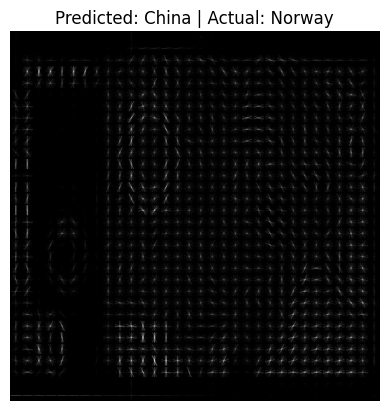

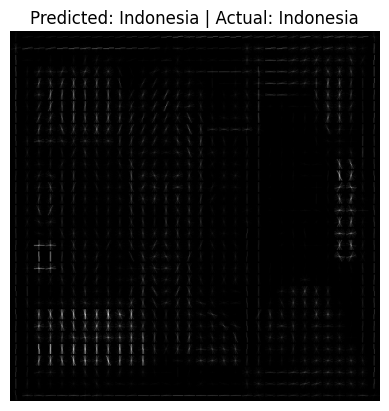

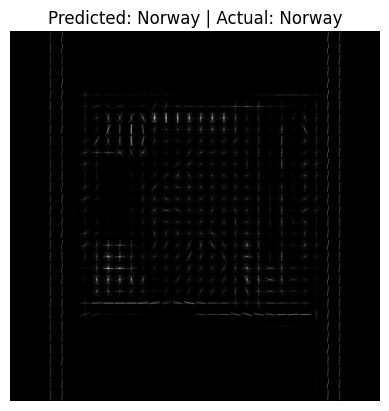

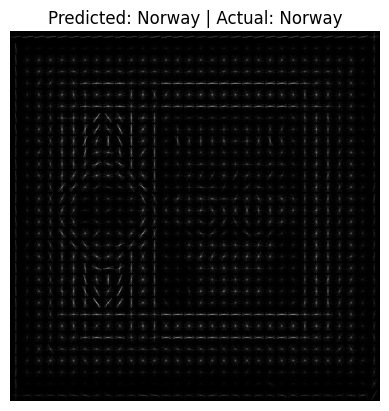

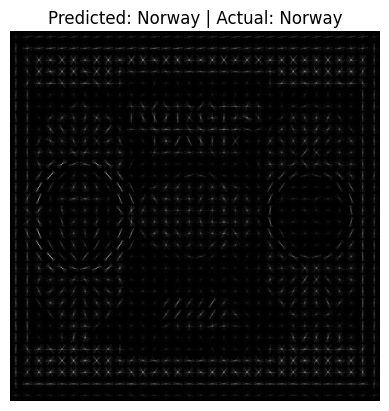

In [11]:
for i in np.random.randint(0, len(X_test), 5):
    img = X_test[i].reshape(512, 512)
    plt.title(f"Predicted: {y_pred[i]} | Actual: {y_test[i]}")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()


- Reduce feature dimensions using PCA to improve efficiency and possibly model performance.



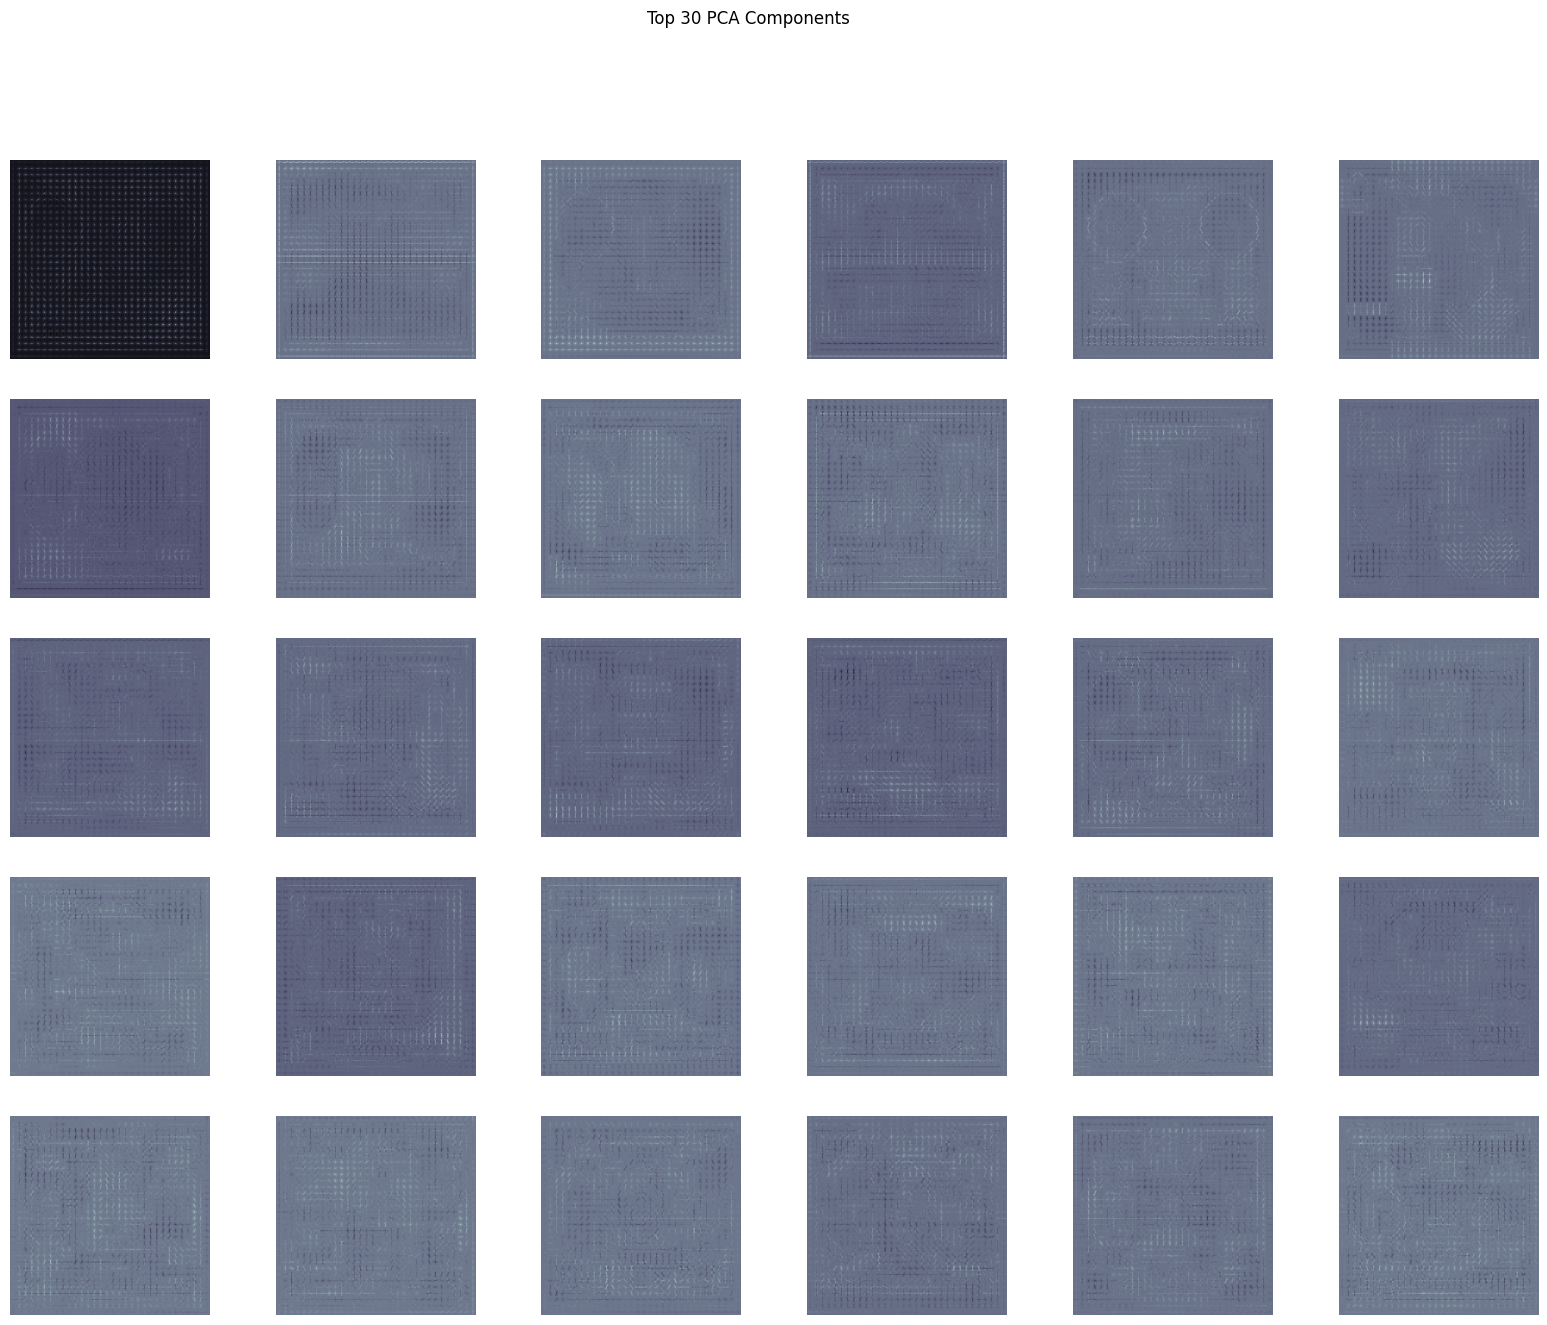

PCA Accuracy: 0.75
PCA Confusion Matrix:
 [[11  0  4]
 [ 2  8  1]
 [ 1  2 11]]


In [12]:
pca = decomposition.PCA()
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


# Show what kind of patterns the top 30 PCA components are capturing in image data.


plt.figure(figsize=(20, 15))
for i in range(30):
    plt.subplot(5, 6, i+1)
    plt.imshow(pca.components_[i].reshape(512, 512), cmap='bone')
    plt.axis('off')
plt.suptitle("Top 30 PCA Components")
plt.show()

# Train and evaluate SVM again but now using reduced PCA-transformed features.


clf_pca = svm.SVC(C=1.0, random_state=1)
clf_pca.fit(X_train_pca, y_train)

y_pred_pca = clf_pca.predict(X_test_pca)
print("PCA Accuracy:", metrics.accuracy_score(y_test, y_pred_pca))
print("PCA Confusion Matrix:\n", confusion_matrix(y_test, y_pred_pca))


- See how PCA-transformed predictions look visually and whether they match actual labels.



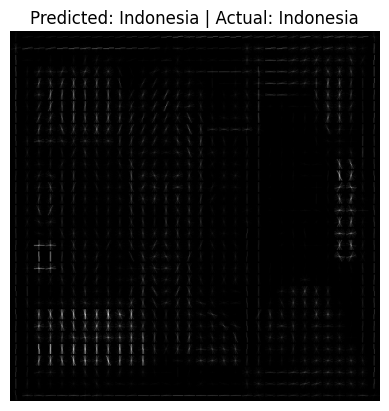

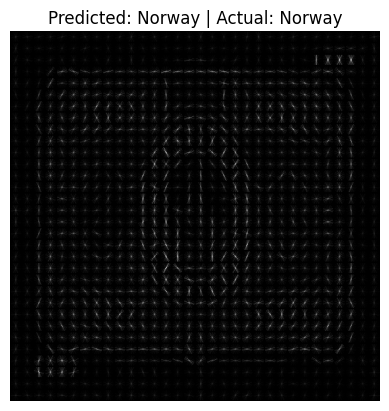

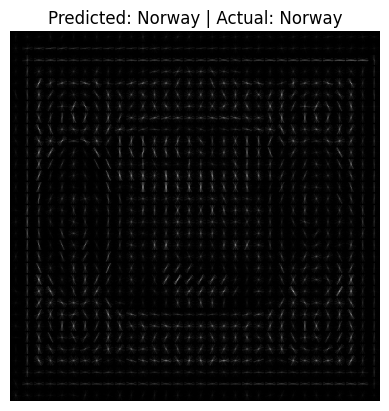

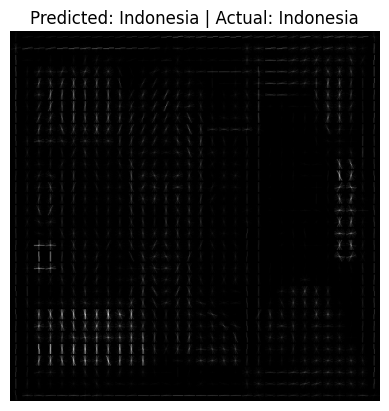

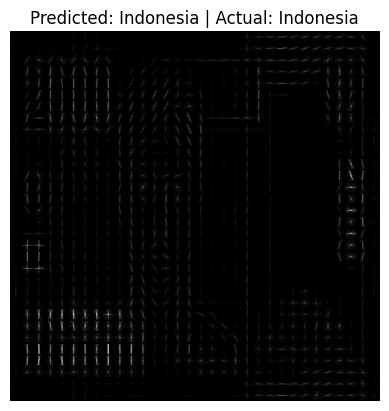

In [13]:
for i in np.random.randint(0, len(X_test), 5):
    img = X_test[i].reshape(512, 512)
    plt.title(f"Predicted: {y_pred_pca[i]} | Actual: {y_test[i]}")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
